# VGG16 이미지 생성기로 모델학습

In [2]:
# !pip install tensorflow

  Using cached protobuf-3.17.3-cp38-cp38-win_amd64.whl (909 kB)
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=e1c364788dfcdbd5c3f52696f74dd2c511b46c47b7805da3425b44240fdfa5b5
  Stored in directory: c:\users\junoe\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=19571 sha256=f69f9277bd9645509569841667d057e0bf21e6913c6592ed23e713dca150cf61
  Stored in directory: c:\users\junoe\appdata\local\pip\cache\wheels\5f\fd\9e\b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
Successfully built termcolor wrapt
  Attempting uninstall: requests
    Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.11.2
    Uninstalling wrapt-1.11.2:
      Successfully uninstalled wrapt-1.11.2
  Attempting uninstall: h

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda 4.10.3 requires ruamel_yaml_conda>=0.11.14, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
# !pip uninstall -y h5py
# !pip install -U h5py==2.10.0

In [2]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])



### train/test 데이터 분리 방법
---
 - 데이터의 카테고리 비율 normal은 394개, early 144개, advanced 233개
 - 카테고리 비율 차이가 2배 정도는 학습됨, 하지만 그 이상은 어렵다
 - 고양이:강아지 = 99:1 이라면 고양이가 강아지보다 99배 더 많이 학습됨
 - class_weights를 줘서 비율이 적은 카테고리의 학습률을 강하게 할 수 있음
 - train data 은 upsampling 하여 문제를 해결하기도 함
 ---
 - test data 는 한 카테고리당 최소 데이터 갯수는 100 개 이상
 - test data 는 downsampling으로 카테고리별로 데이터 갯수 맞추는 것 중요

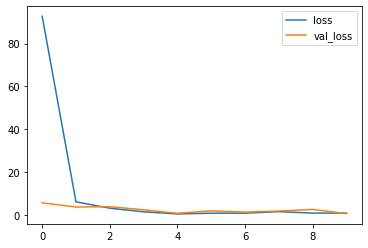

loss =  1.058803677558899 , val_loss =  0.7919926643371582


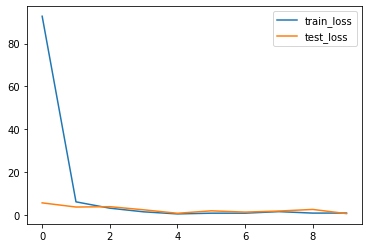

C:\Users\JuNoe\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss= 0.7919926047325134
acc= 0.7141008973121643


C:\Users\JuNoe\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


predicted category index = 2
predicted category name = normal


In [3]:
import os

import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import VGG16

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]



conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(10, activation='softmax'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=vgg16.preprocess_input  # vgg16 전용 데이터전처리
    # https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input
).flow_from_directory(   # https://keras.io/api/preprocessing/image/
    
#       "dogs_prepared/train",
      "data/train", # 디렉토리에는 서브디렉토리들이 있고 각 서브디렉토리에 카테고리 클래스들이
                    # 분류되어 들어가 있어야한다.
                    # 그러면 자동으로 y값인 라벨이 붙여진다.
    
      target_size=(224,224), # (height, width)
                             # default = (256, 256)
                             # 2차원 데이터의 사이즈를 조정함
    
      batch_size=64,    # 데이터를 GPU코어에 몇 개씩 호출할 것인지 결정
    
      class_mode='sparse'  # 'sparse'는 1D integer labels
                           # 'binary'는 1D binary labels
                           # 'categorical'는 2D one-hot encoded labels
                           # 'input'는 input 이미지와 같은 값(=autoencoder)
                           # 입력하지 않으면 어떤 라벨도 붙지 않고 batch size 만큼의
                           # 이미지 데이터를 생성한다. model.predict()에 유용
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
#       "dogs_prepared/test",
      "data/test",  
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)


history = model.fit_generator(  # https://keras.io/ko/models/sequential/
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  # 모든 클래스의 총 데이터 갯수/배치사이즈
      validation_steps=test_data_generator.samples/64,      
      epochs=10,
      verbose=1,
      callbacks=callbacks
)

pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.show()

loss, acc = model.evaluate_generator(  
      test_data_generator,   # 이미지생성기로 데이터를 만들어내기 때문에 validation_data와 같은 
                             # 방식으로 이용해도 된다. 하지만 정말로 다른 데이터를 만드는지 의문(?)
      steps=test_data_generator.samples/64 # steps: 평가가 한 회 완료되었음을 선언하기까지
                                           # 단계(샘플 배치)의 총 개수,
                                           # 디폴트 값인 None의 경우 고려되지 않는다.
)
print("loss=", loss)
print("acc=", acc)

y_ = model.predict_generator(
      test_data_generator,
      steps=test_data_generator.samples/64
)

custom_labels = list(test_data_generator.class_indices.keys()) 
# flow_from_directory의 class_indices 속성은 클래스 이름과 클래스 색인 간 매핑을 담은
# 딕셔너리를 얻을 수 있다.
# {'advanced': 0, 'early': 1, 'normal': 2}
                                                               
predicted = np.argmax(y_, axis=1)
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


### y_ 값
```
y_

array([[9.85726595e-01, 1.41775580e-02, 9.58487071e-05],
       [4.16354858e-04, 6.96324976e-04, 9.98887360e-01],
       [1.31447456e-16, 3.58788079e-14, 1.00000000e+00],
       [6.68997109e-01, 2.94169903e-01, 3.68329771e-02],
       [1.17545040e-23, 6.31817475e-21, 1.00000000e+00],
       [7.31577575e-02, 8.58776927e-01, 6.80653527e-02],
       [6.30605013e-10, 5.45418433e-10, 1.00000000e+00],
```

## bach_size를 16으로 변경

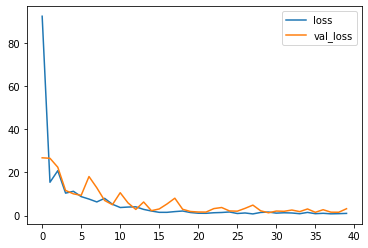

loss =  1.0176430940628052 , val_loss =  3.182697057723999
Epoch 00040: early stopping


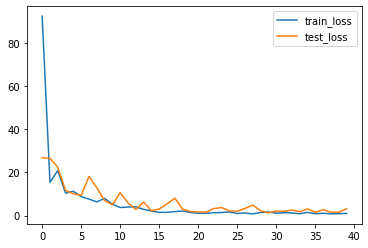

loss= 2.7079951763153076
acc= 0.6057692170143127
predicted category index = 2
predicted category name = normal


In [9]:
import os

import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import VGG16

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]



conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(10, activation='softmax'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
#       "dogs_prepared/train",
      "data/train",
      target_size=(224,224),
      batch_size=16,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
#       "dogs_prepared/test",
      "data/test",
      target_size=(224,224),
      batch_size=16,
      class_mode='sparse'
)


history = model.fit_generator(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      validation_steps=test_data_generator.samples/64,      
      epochs=200,
      verbose=1,
      callbacks=callbacks
)

pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.show()

loss, acc = model.evaluate_generator(
      test_data_generator,
      steps=test_data_generator.samples/64
)
print("loss=", loss)
print("acc=", acc)

y_ = model.predict_generator(
      test_data_generator,
      steps=test_data_generator.samples/64
)

custom_labels = list(test_data_generator.class_indices.keys()) # ADDED
predicted = np.argmax(y_, axis=1)
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


In [10]:
# GPU 확인 코드
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1338070820966703560
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4848943104
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13773781042848717418
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# DenseNet 이미지 생성기로 모델학습

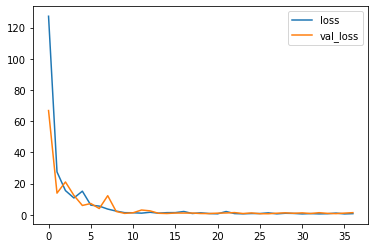

loss =  0.744613528251648 , val_loss =  1.3833425045013428
Epoch 00037: early stopping


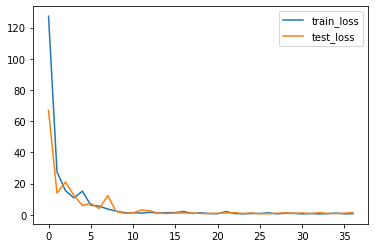

C:\Users\JuNoe\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss= 1.2806625366210938
acc= 0.5817307829856873


C:\Users\JuNoe\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


predicted category index = 0
predicted category name = advanced


In [3]:
import os

import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# from tensorflow.keras.applications import vgg16
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import densenet   # Densenet library
from tensorflow.keras.applications.densenet import DenseNet121

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]



conv_layers = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])


train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=densenet.preprocess_input # densenet 전용 데이터 전처리
).flow_from_directory(
      "data/train",
      target_size=(224,224),
      batch_size=16,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=densenet.preprocess_input # densenet 전용 데이터 전처리
).flow_from_directory(
      "data/test",
      target_size=(224,224),
      batch_size=16,
      class_mode='sparse'
)

history = model.fit_generator(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      validation_steps=test_data_generator.samples/64,      
      epochs=200,
      verbose=1,
      callbacks=callbacks
)

pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.show()

loss, acc = model.evaluate_generator(
      test_data_generator,
      steps=test_data_generator.samples/64
)
print("loss=", loss)
print("acc=", acc)

y_ = model.predict_generator(
      test_data_generator,
      steps=test_data_generator.samples/64
)

custom_labels = list(test_data_generator.class_indices.keys()) # ADDED
predicted = np.argmax(y_, axis=1)
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])
